
### Установим базовые настройки для обучения
В качестве размера батча лучшие результаты обучения модели достигались при количестве картинок 6-8 в батче. Тестирование модели и отладка проводились в основном в течение 70 эпох, за это время можно было понять, обучается ли в целом модель и есть ли шанс на улучшение ее качества.
Для наилучшего результата в конце будем будем обучать модель на протяжении 200 эпох

In [1]:
NUM_WORKERS = 1
EPOCHS = 200
BATCH_SIZE = 8 

import torch
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device('cpu')
    print('No GPU, Using CPU instead')

Using GPU: Tesla T4


### Обучение модели проводилось в ноутбуке кэггл, так как платформа предоставляет GPU обычным пользователям
Кэггл позволяет загрузить до 1000 картинок из любого датасета, поэтому количество картинок, доступных для обучения было сокращено до 1000. 

Будем обучать сверточную нейросеть (по большей части) со слоем LSTM предсказывать последовательность наиболее вероятно встречающихся лейблов, соответствующих символам, изображенным на картинке, на предобработанных картинках из датасета капчей. 

В качестве "финального" лейбла выступает название картинки без учета разрешения. На выходе из модели предсказанная последовательность будет декодироваться и сравниваться с оригинальным лейблом картинки, считаться ошибка CER. 

Предобработаем названия картинок для того, чтобы в дальнейшем применить к ним LabelEncoder и получить численное представление каждого лейбла для обучения. Единицей предсказания модели будет цифра (закодированный символ) из числа всех символов, присутствующих в лейблах и 'пустого' символа. Нет особого смысла брать весь алфавит и все цифры в качестве всех возможных лейблов, так как для данного датасета нам известны все лейблы (нет скрытой валидационной выборки) и можно сузить "круг поиска"

Загрузим датасет, указав путь к нему, проанализируем лейблы

In [2]:
import os
import numpy as np

path = '/kaggle/input/sample/captcha/'
image_names_lst = os.listdir(path)
image_paths = [path + image_path for image_path in image_names_lst]
labels = [lab[:-4] for lab in image_names_lst]
labels = [[char for char in label] for label in labels]
labels_all = [char for chars in labels for char in chars]
labels[:2], labels_all[:10], image_paths[2]

([['6', 'n', '6', 'g', 'g'], ['f', 'n', 'c', 'n', 'b']],
 ['6', 'n', '6', 'g', 'g', 'f', 'n', 'c', 'n', 'b'],
 '/kaggle/input/sample/captcha/nxf2c.jpg')

In [3]:
print('В моем датасете картинок всего', len(image_paths), 'элементов')

В моем датасете картинок всего 1000 элементов


### Посмотрим на первые картинки в датасете

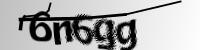

In [4]:
from PIL import Image
Image.open(image_paths[0]).convert('RGB')

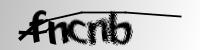

In [5]:
Image.open(image_paths[1]).convert('RGB')

### Проверим расширения всех файлов
Так как из-за этого может потребоваться предобрабатывать некоторые картинки отдельно.

In [6]:
extensions = [i[-3:] for i in image_names_lst]
print(*np.unique(extensions))

jpg png


В датасете присутствуют jpg, png картинки. Они отличаются числом каналов. Данные картинки мы будем конвертировать в RGB изображение с помощью библиотеки PIL, так как 4й канал особо не играет роли в нашей задаче - картинки черно-белые.

Так как картинки черно-белые, мы могли бы их приводить к одноканальному изображению и подавать в модель, но тогда число обучаемых весов в первом слое нейросети пришлось бы увеличивать пропорционально. Первоначально какие-либо изменения картинки не использовались и анализировалось 3х канальное изображение.
Обучение модели на трехканальном изображении происходило лучше (разница в 10% accuracy), чем на одноканальном, хоть и предобработанном (использование трешхолдинга, попытки избавиться от шумов и полос с помощью erode, opening, dilation) при одинаковой структуре нейросети. Поэтому в данном случае будет использоваться трехканальное изображение RGB, так как хорошего качества с использованием одноканального изображения добиться не получилось, не усложняя при этом модель еще больше

In [7]:
from PIL import Image
jpgs = [i for i in image_paths if i[-3:] == 'jpg']
pngs = [i for i in image_paths if i[-3:] == 'png']
np.array(Image.open(jpgs[0])).shape, np.array(Image.open(pngs[0])).shape

((50, 200, 3), (50, 200, 4))

### Убедимся, что все изображения имеют одинаковый размер

In [8]:
for img in image_paths:
    h, w, c = np.array(Image.open(jpgs[0]).convert('RGB')).shape
    if h != 50 or w != 200:
        print(img)
        break

### Таким образом, все предобработанные картинки будут иметь одинаковые размеры (HxWxC)

In [9]:
np.array(Image.open(jpgs[0]).convert('RGB')).shape, np.array(Image.open(pngs[0]).convert('RGB')).shape

((50, 200, 3), (50, 200, 3))

### Воспользуемся кодировкой лейблов 
Так как мы будем угадывать лейбл картинки путем генерации последовательных символов, нам нужно закодировать все имеющиеся в капчах символы в классы. Из всех встречающихся символов и цифр получилось 19 уникальных символов, добавим к ним еще один лейбл - нулевой, который будет играть роль пустого токена (лейбла). Данный лейбл необходим для распознавания последовательности с повторяющимися символами, чтобы при обратном декодировании предсказанной последовательности эти символы не склеивались в один

In [10]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(labels_all)

labels_enc = [encoder.transform(x) for x in labels]
labels_enc = np.array(labels_enc) + 1
print('Original label', image_names_lst[0])
print('Example of lable encoded', labels_enc[0])
print('Number of classes', len(encoder.classes_))

Original label 6n6gg.png
Example of lable encoded [ 5 15  5 13 13]
Number of classes 19


Оказалось, что символ n встречается примерно в 2 раза чаще, чем остальные лейблы

In [11]:
labels_dict = {}
for lbl in labels_all:
    cnt = labels_dict.get(lbl, 0) + 1
    labels_dict[lbl] = cnt
print('Наиболее встречающиеся символы и их количество в датасете:', sorted([(lbl, cnt) for (lbl, cnt) in labels_dict.items()], key=lambda x:x[1], reverse=True)[:3])

Наиболее встречающиеся символы и их количество в датасете: [('n', 498), ('4', 269), ('5', 269)]


### Разделим выборку на трейн и тест 
Разделим выборку 80:20

In [12]:
from sklearn.model_selection import train_test_split
train_imgs, val_imgs, train_labels, val_labels, train_lab_orig, val_lab_orig = train_test_split(image_paths, labels_enc, labels, test_size=0.2, random_state=1234)

In [13]:
# Проверим данные train
train_imgs[0], train_labels[0], train_lab_orig[0]

('/kaggle/input/sample/captcha/nbf8m.png',
 array([15,  8, 12,  7, 14]),
 ['n', 'b', 'f', '8', 'm'])

In [14]:
val_imgs[0], val_labels[0], val_lab_orig[0]

('/kaggle/input/sample/captcha/fbp2c.png',
 array([12,  8, 16,  1,  9]),
 ['f', 'b', 'p', '2', 'c'])

### Создадим класс датасета для нашей выборки
В качестве элемента датасета будет возвращаться пара значений - закодированный лейбл и тензор изображения, к которому уже применены трансформации.

В качестве дополнительных трансформаций проводила эксперименты по добавлению аугментаций изображений, например, рандомный поворот изображения на 2-8 градусов по вертикали. Казалось, что рандомный поворот изображений поможет модели лучше распознавать символы на картинках, так на оригинальных изображениях видно, что некоторые символы на капче могут находится под наклоном. Однако данная аугментация не дала прироста к качеству. "Слипшиеся" символы стали еще менее различимыми при повороте, качество модели падало на 5-10%.

Также казалось, что дополнительное размытие картинок может помочь модели лучше распознавать шумные символы, которые в большом количестве присутсвуют в датасете. На деле оказалось, что GaussianBlur тоже не дает какого-либо прироста к качеству, но и сильно не ухудшает распознавание модели. В итоге аугментации решено было не применять, так как их польза в моем случае была спорной.

In [39]:
from torch.utils.data import Dataset
class TorchDataset(Dataset):
    def __init__(self, image_paths, labels_enc, transform_composed=None):
        self.img_paths = image_paths
        self.labels = labels_enc
        self.transforms = transform_composed
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB') 
        img_tensor = self.transforms(img)
        return {
            'image': img_tensor,
            'label':torch.tensor(label).long()
        } 

В качестве применяемых трансформаций изображения только приведение изображения к тензору + нормализация изображения со средним и стандартным отклонением, используемыми в датасете Imagenet.

In [40]:
from torchvision import transforms
transforms_comp = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Создадим экземпляры класса датасет и даталоадеры для итеративного процесса обучения
Валидационный датасет перемешивать не нужно. Передаем наши базовые настройки сюда

In [41]:
# Creating train, val dataloaders
import torch
from torch.utils.data import DataLoader

train_dataset = TorchDataset(train_imgs, train_labels, transform_composed=transforms_comp)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

val_dataset = TorchDataset(val_imgs, val_labels, transform_composed=transforms_comp)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False) # no shuffle for val

### Опишем класс модели и определим ее слои
В качестве размера ядер сверток рассматривались ядра (3, 3), (4, 3), (5, 3), (6, 3), (3, 4), (3, 6).
Модель с ядром (3, 3) обучалась хуже, чем с прямоугольными, вероятно это связано с тем, что символ или цифра на картинке обычно вытянута по одной из осей изображения. Горизонтальные ядра (3, 6) давали лучший результат обучения (более быстрое падение ошибки на трейн и тест выборках). Возможно, это связано с тем, что по горизонтали паттерны различных символов более отличимы, поэтому модель с прямоугольными вытянутыми ядрами может с большей эффективностью заучивать паттерны, характерные для различных символов.

В качестве основы модели используются сверточные слои с различным числом каналов, выходной слой - линейный с числом выходов = числу классов (уникальных лейблов + blank). Также в модели присутствует слой LSTM
В качестве функции потерь взят CTCLoss из библиотеки торч, так как в нашей задаче несегментированную последовательность данных (символы на картинке) нужно сопоставить некоторому буквенно-символьному лейблу (https://pytorch.org/docs/1.8.0/_modules/torch/nn/modules/loss.html#CTCLoss), где blank - лейбл, соответствующий пустому лейблу.

In [42]:
from torch import nn
from torch.nn import functional as F

class CaptchaModel(nn.Module):
    def __init__(self, num_classes):
        super(CaptchaModel, self).__init__()
        self.conv_1 = nn.Conv2d(3, 256, kernel_size=(3, 6), padding=(1, 1))
        self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.drop_0 = nn.Dropout(0.2)
        self.conv_2 = nn.Conv2d(256, 64, kernel_size=(3, 6), padding=(1, 1))
        self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.linear_1 = nn.Linear(768, 64)
        self.drop_1 = nn.Dropout(0.2)
        self.lstm = nn.LSTM(64, 32, bidirectional=True, num_layers=1, dropout=0.25, batch_first=True)  
        self.output = nn.Linear(64, num_classes + 1)

    def forward(self, images, labels=None):
        batch = images.size()[0]
        x = F.relu(self.conv_1(images))
        x = self.pool_1(x)
        x = F.relu(self.conv_2(x))
        x = self.drop_0(x)

        x = self.pool_2(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(batch, x.size(1), -1)

        x = F.relu(self.linear_1(x))
        x = self.drop_1(x)
        x, _ = self.lstm(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if labels is not None:
            log_probs = F.log_softmax(x, 2)
            in_lengths = torch.full(size=(batch,), fill_value=log_probs.size(0), dtype=torch.int32)
            lbl_lengths = torch.full(size=(batch,), fill_value=labels.size(1), dtype=torch.int32)
            loss = nn.CTCLoss(blank=0)(log_probs, labels, in_lengths, lbl_lengths)
            return x, loss
        return x, None

In [43]:
from tqdm import tqdm

### Напишем функцию обучения одной эпохи, валидации
В цикле обучения будем итерироваться по числу эпох (EPOCHS), обучать модель и следить за качеством предсказания модели - считать ошибку CER предсказанных лейблов

In [44]:
def train_one_epoch(model, train_dataloader, optimizer):
    train_losses = 0
    model.train()
    for data in tqdm(train_dataloader):
        imgs, labels = data['image'], data['label']
        imgs, labels =  imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        y_pred, loss = model(imgs, labels)
        train_losses += loss.item()
        loss.backward()
        optimizer.step()
    train_epoch_loss = train_losses / len(train_dataloader) # ошибка на всей выборке
    return y_pred, train_epoch_loss

def predict(model, val_dataloader):
    pred_losses = 0
    losses, all_preds = [], []
    model.eval()
    with torch.no_grad():
        for data in tqdm(val_dataloader):
            imgs, labels = data['image'], data['label']
            imgs, labels =  imgs.to(DEVICE), labels.to(DEVICE)
            y_pred, loss = model(imgs, labels)
            pred_losses += loss.item()
            all_preds.append(y_pred)
    val_epoch_loss = pred_losses / len(val_dataloader)
    return all_preds, val_epoch_loss

### Для декодирования предсказанной последовательности напишем функцию-декодеровщик
Данная функция получает батч с предсказанными последовательностями на вход, сравнивает вероятности появления всех лейблов в качестве следующего символа в каждый момент времени и возвращает декодированную последовательность наиболее вероятных символов для всего батча. 

Так как ошибка CER в том числе учитывает число символов, которые надо удалить из предсказанного лейбла, сначала ограничения на длину предсказанного лейбла не было. В таком случае ошибка CER была немного выше, чем в случае, когда в коде декодеровщика проверяется длина последовательности. 

Возможно, декодеровщик реализован не совсем верно, так как возникали проблемы с анализом последовательных символов различных лейблов. Однако, при большом числе эпох обучения данная настройка декодеровщика не влияет на результат, модель хорошо обучается 

In [45]:
# Измененный декодеровщик после учтения ошибок первого типа (последовательность длиннее 5 символов)
def my_predictions_decoder_new(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds, probs = torch.argmax(torch.softmax(preds, 2), 2), torch.max(torch.softmax(preds, 2), 2).values
    lbls = []
    for line, line_probs in zip(preds, probs):
        seq, ans = [], []
        idx = -1
        for el, proba in zip(line, line_probs):
            idx += 1
            if el == 0 or idx == len(line) - 1:
                if seq:
                    new_el, proba = sorted(seq, key=lambda x: x[1], reverse=True)[0]
                    ans.append((str(new_el), proba))
                seq = []
                continue
            elif el != 0:
                seq.append((el.cpu().numpy(), proba.cpu().detach().numpy()))
        if len(ans) > 5:
            ans = [el[0] for el in ans if el in sorted(ans, key=lambda x: x[1], reverse=True)[:5]]
        else:
            ans = [el[0] for el in ans]
        ans = [encoder.inverse_transform([int(i) - 1])[0] for i in ans[:]]
        lbls.append(''.join(ans))
    return lbls

### Обучим модель в цикле и замерим метрику CER из библиотеки torchmetrics на каждой эпохе. 
В конце сделаем предсказание уже обученной моделью и посмотрим на лейблы, которые неверно угадываются моделью

### Модель не всегда успешно обучается, зафиксировать результат зерном все же не получилось
Иногда приходится много раз перезапускать код создания и обучения модели

In [46]:
import torchmetrics
import random

# SEED = 1337
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

valid_labels = [''.join(lbl) for lbl in val_lab_orig]
model = CaptchaModel(len(encoder.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, verbose=True)
from sklearn.metrics import accuracy_score
model.parameters

<bound method Module.parameters of CaptchaModel(
  (conv_1): Conv2d(3, 256, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (drop_0): Dropout(p=0.2, inplace=False)
  (conv_2): Conv2d(256, 64, kernel_size=(3, 6), stride=(1, 1), padding=(1, 1))
  (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (linear_1): Linear(in_features=768, out_features=64, bias=True)
  (drop_1): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(64, 32, batch_first=True, dropout=0.25, bidirectional=True)
  (output): Linear(in_features=64, out_features=20, bias=True)
)>

In [66]:
model.to(DEVICE)
for epoch in range(EPOCHS):
    t_pred, t_los = train_one_epoch(model, train_dataloader, optimizer)
    v_pred, v_los = predict(model, val_dataloader)

    my_preds_new = []
    for vp in v_pred:
        
        new_predictions = my_predictions_decoder_new(vp, encoder)
        my_preds_new.extend(new_predictions)

    learn_rate = optimizer.state_dict()['param_groups'][0]['lr']
    cer_new = torchmetrics.functional.char_error_rate(my_preds_new, valid_labels)
    print(f'Epoch: {epoch}, train_loss={t_los}, valid_loss={v_los}  cer_new {cer_new} lr={learn_rate}') 
    scheduler.step(v_los)
    
#     if cer_new < 0.004:
#         print('Acceptable CER achieved! My model cannot do better for now ')
#         break

100%|██████████| 25/25 [00:00<00:00, 52.31it/s]


Epoch: 0, train_loss=4.332673442363739, valid_loss=3.295055961608887  cer_new 1.0 lr=0.003


100%|██████████| 25/25 [00:00<00:00, 49.90it/s]


Epoch: 1, train_loss=3.275475206375122, valid_loss=3.2837648487091062  cer_new 1.0 lr=0.003


100%|██████████| 25/25 [00:00<00:00, 54.87it/s]


Epoch: 2, train_loss=3.2750444841384887, valid_loss=3.285109033584595  cer_new 1.0 lr=0.003


100%|██████████| 25/25 [00:00<00:00, 50.03it/s]


Epoch: 3, train_loss=3.2739386916160584, valid_loss=3.2950975608825686  cer_new 1.0 lr=0.003


100%|██████████| 25/25 [00:00<00:00, 51.36it/s]


Epoch: 4, train_loss=3.2751267099380494, valid_loss=3.2892534255981447  cer_new 1.0 lr=0.003


100%|██████████| 25/25 [00:00<00:00, 52.65it/s]


Epoch: 5, train_loss=3.2751596212387084, valid_loss=3.2878069400787355  cer_new 1.0 lr=0.003


100%|██████████| 25/25 [00:00<00:00, 51.93it/s]


Epoch: 6, train_loss=3.2729609608650208, valid_loss=3.2881462669372556  cer_new 1.0 lr=0.003


100%|██████████| 25/25 [00:00<00:00, 52.72it/s]


Epoch: 7, train_loss=3.277965958118439, valid_loss=3.305683832168579  cer_new 1.0 lr=0.003
Epoch 00008: reducing learning rate of group 0 to 2.1000e-03.


100%|██████████| 25/25 [00:00<00:00, 48.72it/s]


Epoch: 8, train_loss=3.2709388184547423, valid_loss=3.2862441539764404  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.00it/s]


Epoch: 9, train_loss=3.272306261062622, valid_loss=3.2901480865478514  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.51it/s]


Epoch: 10, train_loss=3.2718869924545286, valid_loss=3.286666841506958  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 50.33it/s]


Epoch: 11, train_loss=3.2715944051742554, valid_loss=3.2840001678466795  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 50.63it/s]


Epoch: 12, train_loss=3.2725415515899656, valid_loss=3.279055881500244  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.64it/s]


Epoch: 13, train_loss=3.2685064840316773, valid_loss=3.2916158294677733  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.14it/s]


Epoch: 14, train_loss=3.2700522994995116, valid_loss=3.290837497711182  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 48.07it/s]


Epoch: 15, train_loss=3.2682425737380982, valid_loss=3.285925178527832  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 50.62it/s]


Epoch: 16, train_loss=3.272639629840851, valid_loss=3.2863512420654297  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 45.51it/s]


Epoch: 17, train_loss=3.273451020717621, valid_loss=3.28944766998291  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 51.16it/s]


Epoch: 18, train_loss=3.2702692484855653, valid_loss=3.2749532890319824  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 42.39it/s]


Epoch: 19, train_loss=3.269682538509369, valid_loss=3.3742773723602295  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 50.80it/s]


Epoch: 20, train_loss=3.2670796251297, valid_loss=3.2709652519226076  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.59it/s]


Epoch: 21, train_loss=3.2617963314056397, valid_loss=3.26365180015564  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 49.89it/s]


Epoch: 22, train_loss=3.2484197354316713, valid_loss=3.230804834365845  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.48it/s]


Epoch: 23, train_loss=3.1389822721481324, valid_loss=3.017411890029907  cer_new 1.0 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.30it/s]


Epoch: 24, train_loss=2.8242685294151304, valid_loss=2.391942081451416  cer_new 0.9710000157356262 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 55.04it/s]


Epoch: 25, train_loss=2.124413951635361, valid_loss=1.6411799430847167  cer_new 0.718999981880188 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 51.84it/s]


Epoch: 26, train_loss=1.5924462723731994, valid_loss=1.098911340236664  cer_new 0.39899998903274536 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.72it/s]


Epoch: 27, train_loss=1.2371296364068984, valid_loss=0.8418741393089294  cer_new 0.3179999887943268 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.44it/s]


Epoch: 28, train_loss=1.0709688150882721, valid_loss=0.7052778029441833  cer_new 0.210999995470047 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 54.56it/s]


Epoch: 29, train_loss=0.9054816681146621, valid_loss=0.6221650087833405  cer_new 0.17399999499320984 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 44.01it/s]


Epoch: 30, train_loss=0.8730818963050843, valid_loss=0.6361702108383178  cer_new 0.20800000429153442 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.66it/s]


Epoch: 31, train_loss=0.8265134429931641, valid_loss=0.5137943923473358  cer_new 0.14100000262260437 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 51.95it/s]


Epoch: 32, train_loss=0.6999279025197029, valid_loss=0.3877961218357086  cer_new 0.12800000607967377 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.23it/s]


Epoch: 33, train_loss=0.6168646413087845, valid_loss=0.36860447585582734  cer_new 0.10499999672174454 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.48it/s]


Epoch: 34, train_loss=0.5713362365961074, valid_loss=0.39808777153491975  cer_new 0.12600000202655792 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.05it/s]


Epoch: 35, train_loss=0.5972597515583038, valid_loss=0.34946564853191375  cer_new 0.11100000143051147 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.62it/s]


Epoch: 36, train_loss=0.5207012850046158, valid_loss=0.28761468768119813  cer_new 0.07000000029802322 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 37.56it/s]


Epoch: 37, train_loss=0.49448456823825837, valid_loss=0.32304370880126954  cer_new 0.08500000089406967 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 51.45it/s]


Epoch: 38, train_loss=0.5012737980484963, valid_loss=0.3173135343194008  cer_new 0.10000000149011612 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.59it/s]


Epoch: 39, train_loss=0.4302197442948818, valid_loss=0.23484033197164536  cer_new 0.05900000035762787 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 46.12it/s]


Epoch: 40, train_loss=0.4701661488413811, valid_loss=0.3255392026901245  cer_new 0.11500000208616257 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 50.83it/s]


Epoch: 41, train_loss=0.47810086905956267, valid_loss=0.22692734241485596  cer_new 0.06599999964237213 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.91it/s]


Epoch: 42, train_loss=0.4173152430355549, valid_loss=0.26996340095996857  cer_new 0.05700000002980232 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 50.85it/s]


Epoch: 43, train_loss=0.38880986407399176, valid_loss=0.2305808785557747  cer_new 0.06499999761581421 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 46.27it/s]


Epoch: 44, train_loss=0.37203852355480194, valid_loss=0.20956992447376252  cer_new 0.07699999958276749 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.90it/s]


Epoch: 45, train_loss=0.3819971463084221, valid_loss=0.2213681870698929  cer_new 0.05999999865889549 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 51.61it/s]


Epoch: 46, train_loss=0.40005576744675636, valid_loss=0.23732912600040434  cer_new 0.08399999886751175 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 49.39it/s]


Epoch: 47, train_loss=0.3346305952966213, valid_loss=0.1886507326364517  cer_new 0.05299999937415123 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 51.83it/s]


Epoch: 48, train_loss=0.3455639284849167, valid_loss=0.1972775164246559  cer_new 0.0560000017285347 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.59it/s]


Epoch: 49, train_loss=0.33733714789152147, valid_loss=0.20125535935163497  cer_new 0.061000000685453415 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 51.65it/s]


Epoch: 50, train_loss=0.3342754226922989, valid_loss=0.18930142343044282  cer_new 0.0560000017285347 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 50.01it/s]


Epoch: 51, train_loss=0.3351611922681332, valid_loss=0.20111540645360948  cer_new 0.061000000685453415 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.27it/s]


Epoch: 52, train_loss=0.3213131639361382, valid_loss=0.1827748343348503  cer_new 0.06700000166893005 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.85it/s]


Epoch: 53, train_loss=0.2999547288566828, valid_loss=0.16657638400793076  cer_new 0.04800000041723251 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 48.51it/s]


Epoch: 54, train_loss=0.30077830612659456, valid_loss=0.21590581625699998  cer_new 0.06300000101327896 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.12it/s]


Epoch: 55, train_loss=0.29363358475267887, valid_loss=0.17949340611696243  cer_new 0.05900000035762787 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 43.21it/s]


Epoch: 56, train_loss=0.29888136439025403, valid_loss=0.2132380086183548  cer_new 0.07599999755620956 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 40.57it/s]


Epoch: 57, train_loss=0.3046260407567024, valid_loss=0.17015947222709657  cer_new 0.0430000014603138 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.95it/s]


Epoch: 58, train_loss=0.2796551012992859, valid_loss=0.15763187438249587  cer_new 0.05400000140070915 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.43it/s]


Epoch: 59, train_loss=0.2597827907279134, valid_loss=0.15975967213511466  cer_new 0.050999999046325684 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.98it/s]


Epoch: 60, train_loss=0.25374987844377755, valid_loss=0.2387809172272682  cer_new 0.07900000363588333 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 50.86it/s]


Epoch: 61, train_loss=0.2885170876979828, valid_loss=0.16729987725615503  cer_new 0.04399999976158142 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 52.09it/s]


Epoch: 62, train_loss=0.2631244444102049, valid_loss=0.17045293420553206  cer_new 0.06300000101327896 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 54.35it/s]


Epoch: 63, train_loss=0.26818727247416974, valid_loss=0.17720258370041847  cer_new 0.06400000303983688 lr=0.0021


100%|██████████| 25/25 [00:00<00:00, 53.05it/s]


Epoch: 64, train_loss=0.271898265555501, valid_loss=0.18272943317890167  cer_new 0.05400000140070915 lr=0.0021
Epoch 00065: reducing learning rate of group 0 to 1.4700e-03.


100%|██████████| 25/25 [00:00<00:00, 53.72it/s]


Epoch: 65, train_loss=0.26745185151696205, valid_loss=0.1301644992828369  cer_new 0.035999998450279236 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 51.29it/s]


Epoch: 66, train_loss=0.24120579928159713, valid_loss=0.13836318284273147  cer_new 0.03700000047683716 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 36.68it/s]


Epoch: 67, train_loss=0.23372071020305157, valid_loss=0.14514063984155656  cer_new 0.04699999839067459 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 46.72it/s]


Epoch: 68, train_loss=0.23045349791646003, valid_loss=0.16535502538084984  cer_new 0.04899999871850014 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 53.47it/s]


Epoch: 69, train_loss=0.2072747416049242, valid_loss=0.12376653209328652  cer_new 0.028999999165534973 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 53.77it/s]


Epoch: 70, train_loss=0.21754768542945385, valid_loss=0.13620115891098977  cer_new 0.0430000014603138 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 53.14it/s]


Epoch: 71, train_loss=0.19857285618782045, valid_loss=0.13567877560853958  cer_new 0.04100000113248825 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 52.31it/s]


Epoch: 72, train_loss=0.18779862567782402, valid_loss=0.10995741114020348  cer_new 0.03999999910593033 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 53.19it/s]


Epoch: 73, train_loss=0.20674081347882747, valid_loss=0.11996291071176529  cer_new 0.052000001072883606 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 51.84it/s]


Epoch: 74, train_loss=0.1941216003894806, valid_loss=0.12516369052231313  cer_new 0.032999999821186066 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 44.06it/s]


Epoch: 75, train_loss=0.17763896703720092, valid_loss=0.10305414259433747  cer_new 0.02800000086426735 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 53.17it/s]


Epoch: 76, train_loss=0.18061967385932803, valid_loss=0.1432738047838211  cer_new 0.04800000041723251 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 32.07it/s]


Epoch: 77, train_loss=0.18438595313578843, valid_loss=0.13227828957140444  cer_new 0.04399999976158142 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 43.65it/s]


Epoch: 78, train_loss=0.17903535567224027, valid_loss=0.1338288176059723  cer_new 0.03799999877810478 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 53.32it/s]


Epoch: 79, train_loss=0.19080264564603566, valid_loss=0.10549811653792858  cer_new 0.03200000151991844 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 51.27it/s]


Epoch: 80, train_loss=0.16978330355137586, valid_loss=0.08867773525416851  cer_new 0.020999999716877937 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 52.27it/s]


Epoch: 81, train_loss=0.15434056874364616, valid_loss=0.09848061628639698  cer_new 0.02500000037252903 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 37.02it/s]


Epoch: 82, train_loss=0.15184747777879237, valid_loss=0.10103657759726048  cer_new 0.019999999552965164 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 52.77it/s]


Epoch: 83, train_loss=0.16172189109027385, valid_loss=0.08723299089819193  cer_new 0.017000000923871994 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 53.81it/s]


Epoch: 84, train_loss=0.1623612305894494, valid_loss=0.10688827373087406  cer_new 0.023000000044703484 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 54.00it/s]


Epoch: 85, train_loss=0.15670425614342093, valid_loss=0.08181992646306753  cer_new 0.01899999938905239 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 54.22it/s]


Epoch: 86, train_loss=0.14001312509179115, valid_loss=0.11597883731126785  cer_new 0.01899999938905239 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 39.24it/s]


Epoch: 87, train_loss=0.17068001737818123, valid_loss=0.08994997546076774  cer_new 0.017999999225139618 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 51.20it/s]


Epoch: 88, train_loss=0.16569198008626698, valid_loss=0.1001972907781601  cer_new 0.02500000037252903 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 40.10it/s]


Epoch: 89, train_loss=0.16967516221106052, valid_loss=0.08336848504841328  cer_new 0.019999999552965164 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 52.38it/s]


Epoch: 90, train_loss=0.15468122523277997, valid_loss=0.10488238576799631  cer_new 0.032999999821186066 lr=0.0014699999999999997


100%|██████████| 25/25 [00:00<00:00, 55.06it/s]


Epoch: 91, train_loss=0.15210478249937295, valid_loss=0.08871553584933281  cer_new 0.024000000208616257 lr=0.0014699999999999997
Epoch 00092: reducing learning rate of group 0 to 1.0290e-03.


100%|██████████| 25/25 [00:00<00:00, 54.01it/s]


Epoch: 92, train_loss=0.13380222350358964, valid_loss=0.08412342995405198  cer_new 0.017000000923871994 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 52.25it/s]


Epoch: 93, train_loss=0.15122733864933252, valid_loss=0.09898895934224129  cer_new 0.029999999329447746 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 44.54it/s]


Epoch: 94, train_loss=0.14134262593463062, valid_loss=0.08067452900111675  cer_new 0.01600000075995922 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 50.96it/s]


Epoch: 95, train_loss=0.1266133126989007, valid_loss=0.07902621887624264  cer_new 0.01600000075995922 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 38.86it/s]


Epoch: 96, train_loss=0.11791872654110193, valid_loss=0.06363830545917154  cer_new 0.009999999776482582 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 51.94it/s]


Epoch: 97, train_loss=0.12139205472543836, valid_loss=0.06981847923249006  cer_new 0.013000000268220901 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 54.06it/s]


Epoch: 98, train_loss=0.14169871805235743, valid_loss=0.06640397235751153  cer_new 0.014999999664723873 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 52.50it/s]


Epoch: 99, train_loss=0.12161032056435943, valid_loss=0.061941322851926085  cer_new 0.014000000432133675 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 53.60it/s]


Epoch: 100, train_loss=0.11611515315249563, valid_loss=0.08890365475788713  cer_new 0.017000000923871994 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 52.03it/s]


Epoch: 101, train_loss=0.11729737078770995, valid_loss=0.06593923699110746  cer_new 0.009999999776482582 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 54.01it/s]


Epoch: 102, train_loss=0.10964307450689376, valid_loss=0.0757015785202384  cer_new 0.017000000923871994 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 45.41it/s]


Epoch: 103, train_loss=0.11250686654821038, valid_loss=0.07864301089197397  cer_new 0.014000000432133675 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 53.00it/s]


Epoch: 104, train_loss=0.123444529119879, valid_loss=0.08940833739936352  cer_new 0.014000000432133675 lr=0.0010289999999999997


100%|██████████| 25/25 [00:00<00:00, 53.21it/s]


Epoch: 105, train_loss=0.13123983833938838, valid_loss=0.06422873428091407  cer_new 0.010999999940395355 lr=0.0010289999999999997
Epoch 00106: reducing learning rate of group 0 to 7.2030e-04.


100%|██████████| 25/25 [00:00<00:00, 52.30it/s]


Epoch: 106, train_loss=0.11537271335721017, valid_loss=0.058042495232075456  cer_new 0.006000000052154064 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 54.91it/s]


Epoch: 107, train_loss=0.11132233249954879, valid_loss=0.061269319467246536  cer_new 0.008999999612569809 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 54.73it/s]


Epoch: 108, train_loss=0.1030847761593759, valid_loss=0.06259050283581019  cer_new 0.014999999664723873 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 51.01it/s]


Epoch: 109, train_loss=0.11089229234494269, valid_loss=0.05916754858568311  cer_new 0.00800000037997961 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 52.61it/s]


Epoch: 110, train_loss=0.11655886510387063, valid_loss=0.06797767527401448  cer_new 0.010999999940395355 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 52.26it/s]


Epoch: 111, train_loss=0.0917045908421278, valid_loss=0.056314901914447546  cer_new 0.012000000104308128 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 52.10it/s]


Epoch: 112, train_loss=0.09929778210818768, valid_loss=0.050512939617037775  cer_new 0.00800000037997961 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 46.20it/s]


Epoch: 113, train_loss=0.09540567889809609, valid_loss=0.05797024702653289  cer_new 0.010999999940395355 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 52.38it/s]


Epoch: 114, train_loss=0.08516529764980078, valid_loss=0.049592096172273156  cer_new 0.006000000052154064 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 53.18it/s]


Epoch: 115, train_loss=0.0829200068116188, valid_loss=0.05760254349559545  cer_new 0.009999999776482582 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 50.93it/s]


Epoch: 116, train_loss=0.08594095285050571, valid_loss=0.058151321914047004  cer_new 0.010999999940395355 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 53.58it/s]


Epoch: 117, train_loss=0.08402228890918195, valid_loss=0.050286902748048305  cer_new 0.007000000216066837 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 52.65it/s]


Epoch: 118, train_loss=0.08432222612202167, valid_loss=0.054544744081795216  cer_new 0.006000000052154064 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 53.15it/s]


Epoch: 119, train_loss=0.07161784930154681, valid_loss=0.04854084072634578  cer_new 0.008999999612569809 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 49.12it/s]


Epoch: 120, train_loss=0.0882610444072634, valid_loss=0.05012707989662886  cer_new 0.006000000052154064 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 52.08it/s]


Epoch: 121, train_loss=0.08116547592449934, valid_loss=0.04807941807433963  cer_new 0.007000000216066837 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 52.87it/s]


Epoch: 122, train_loss=0.09101479969918728, valid_loss=0.05898699119687081  cer_new 0.013000000268220901 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 51.69it/s]


Epoch: 123, train_loss=0.08382372985593975, valid_loss=0.05081820246763527  cer_new 0.009999999776482582 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 56.21it/s]


Epoch: 124, train_loss=0.09130814732052386, valid_loss=0.061104255001991986  cer_new 0.010999999940395355 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 51.80it/s]


Epoch: 125, train_loss=0.08492194201797247, valid_loss=0.05042026448994875  cer_new 0.00800000037997961 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 52.04it/s]


Epoch: 126, train_loss=0.08203635977581143, valid_loss=0.054334198851138354  cer_new 0.00800000037997961 lr=0.0007202999999999998


100%|██████████| 25/25 [00:00<00:00, 49.85it/s]


Epoch: 127, train_loss=0.07982270603999496, valid_loss=0.05514832539483905  cer_new 0.009999999776482582 lr=0.0007202999999999998
Epoch 00128: reducing learning rate of group 0 to 5.0421e-04.


100%|██████████| 25/25 [00:00<00:00, 53.18it/s]


Epoch: 128, train_loss=0.07419532212428749, valid_loss=0.0541552940942347  cer_new 0.010999999940395355 lr=0.0005042099999999998


100%|██████████| 25/25 [00:00<00:00, 52.67it/s]


Epoch: 129, train_loss=0.08631867514923215, valid_loss=0.05464808022603393  cer_new 0.010999999940395355 lr=0.0005042099999999998


100%|██████████| 25/25 [00:00<00:00, 51.93it/s]


Epoch: 130, train_loss=0.06653656858950853, valid_loss=0.04337559143081307  cer_new 0.007000000216066837 lr=0.0005042099999999998


100%|██████████| 25/25 [00:00<00:00, 50.97it/s]


Epoch: 131, train_loss=0.06752084383741021, valid_loss=0.050703995805233715  cer_new 0.009999999776482582 lr=0.0005042099999999998


100%|██████████| 25/25 [00:00<00:00, 52.55it/s]


Epoch: 132, train_loss=0.06298954052850604, valid_loss=0.048535367799922825  cer_new 0.00800000037997961 lr=0.0005042099999999998


100%|██████████| 25/25 [00:00<00:00, 49.30it/s]


Epoch: 133, train_loss=0.06676985155791045, valid_loss=0.05356340426951647  cer_new 0.010999999940395355 lr=0.0005042099999999998


100%|██████████| 25/25 [00:00<00:00, 46.71it/s]


Epoch: 134, train_loss=0.07540419766213745, valid_loss=0.053350913356989625  cer_new 0.008999999612569809 lr=0.0005042099999999998


100%|██████████| 25/25 [00:00<00:00, 51.72it/s]


Epoch: 135, train_loss=0.06864739511162042, valid_loss=0.05069801863282919  cer_new 0.008999999612569809 lr=0.0005042099999999998


100%|██████████| 25/25 [00:00<00:00, 50.72it/s]


Epoch: 136, train_loss=0.08792680598795415, valid_loss=0.06485337873920799  cer_new 0.01600000075995922 lr=0.0005042099999999998
Epoch 00137: reducing learning rate of group 0 to 3.5295e-04.


100%|██████████| 25/25 [00:00<00:00, 47.56it/s]


Epoch: 137, train_loss=0.0799732828233391, valid_loss=0.05102724213153124  cer_new 0.008999999612569809 lr=0.0003529469999999999


100%|██████████| 25/25 [00:00<00:00, 51.20it/s]


Epoch: 138, train_loss=0.06842504198197276, valid_loss=0.051151210544630885  cer_new 0.00800000037997961 lr=0.0003529469999999999


100%|██████████| 25/25 [00:00<00:00, 51.36it/s]


Epoch: 139, train_loss=0.06632813042029738, valid_loss=0.04664400663226843  cer_new 0.00800000037997961 lr=0.0003529469999999999


100%|██████████| 25/25 [00:00<00:00, 51.42it/s]


Epoch: 140, train_loss=0.06321227156557142, valid_loss=0.04793722532689571  cer_new 0.00800000037997961 lr=0.0003529469999999999


100%|██████████| 25/25 [00:00<00:00, 35.35it/s]


Epoch: 141, train_loss=0.06261934528127312, valid_loss=0.04543282605707646  cer_new 0.004999999888241291 lr=0.0003529469999999999


100%|██████████| 25/25 [00:00<00:00, 50.65it/s]


Epoch: 142, train_loss=0.06512134465388954, valid_loss=0.04523102718405426  cer_new 0.006000000052154064 lr=0.0003529469999999999
Epoch 00143: reducing learning rate of group 0 to 2.4706e-04.


100%|██████████| 25/25 [00:00<00:00, 51.72it/s]


Epoch: 143, train_loss=0.06731230252422392, valid_loss=0.04431376060470939  cer_new 0.007000000216066837 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 51.98it/s]


Epoch: 144, train_loss=0.0582713116845116, valid_loss=0.04501997007988393  cer_new 0.007000000216066837 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 52.35it/s]


Epoch: 145, train_loss=0.05415061502717435, valid_loss=0.04684705384541303  cer_new 0.00800000037997961 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 50.07it/s]


Epoch: 146, train_loss=0.05544095089659095, valid_loss=0.04416417673230171  cer_new 0.007000000216066837 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 50.65it/s]


Epoch: 147, train_loss=0.05760896706022322, valid_loss=0.04694131880067289  cer_new 0.00800000037997961 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 47.49it/s]


Epoch: 148, train_loss=0.0546312669524923, valid_loss=0.042003842256963256  cer_new 0.007000000216066837 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 50.97it/s]


Epoch: 149, train_loss=0.054606969188898805, valid_loss=0.04393128304742277  cer_new 0.007000000216066837 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 50.44it/s]


Epoch: 150, train_loss=0.05505347852595151, valid_loss=0.0439471398293972  cer_new 0.008999999612569809 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 47.96it/s]


Epoch: 151, train_loss=0.04737966049462557, valid_loss=0.04154828704893589  cer_new 0.006000000052154064 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 52.69it/s]


Epoch: 152, train_loss=0.04402873341459781, valid_loss=0.03931129844859242  cer_new 0.004000000189989805 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 49.63it/s]


Epoch: 153, train_loss=0.05631471374072135, valid_loss=0.041185677479952575  cer_new 0.004999999888241291 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 49.30it/s]


Epoch: 154, train_loss=0.049203445347957314, valid_loss=0.04286848624236882  cer_new 0.006000000052154064 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 47.62it/s]


Epoch: 155, train_loss=0.05341374118812382, valid_loss=0.04505412775091827  cer_new 0.006000000052154064 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 43.15it/s]


Epoch: 156, train_loss=0.04694892444647849, valid_loss=0.04614294411614537  cer_new 0.006000000052154064 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 52.12it/s]


Epoch: 157, train_loss=0.04961233699228615, valid_loss=0.03951881108805537  cer_new 0.004999999888241291 lr=0.0002470628999999999


100%|██████████| 25/25 [00:00<00:00, 48.23it/s]


Epoch: 158, train_loss=0.05328250628896058, valid_loss=0.04010546373203397  cer_new 0.004000000189989805 lr=0.0002470628999999999
Epoch 00159: reducing learning rate of group 0 to 1.7294e-04.


100%|██████████| 25/25 [00:00<00:00, 50.93it/s]


Epoch: 159, train_loss=0.05077957822941244, valid_loss=0.04187139144167304  cer_new 0.004999999888241291 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 48.91it/s]


Epoch: 160, train_loss=0.04903427545446903, valid_loss=0.041519436724483966  cer_new 0.007000000216066837 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 50.57it/s]


Epoch: 161, train_loss=0.049986508460715416, valid_loss=0.04359331019222736  cer_new 0.004999999888241291 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 52.56it/s]


Epoch: 162, train_loss=0.055436475072056055, valid_loss=0.040742714926600455  cer_new 0.004999999888241291 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 52.36it/s]


Epoch: 163, train_loss=0.05446503732353449, valid_loss=0.040261327344924214  cer_new 0.004999999888241291 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 53.46it/s]


Epoch: 164, train_loss=0.04632643462158739, valid_loss=0.03864457804709673  cer_new 0.004000000189989805 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 50.93it/s]


Epoch: 165, train_loss=0.055869176825508474, valid_loss=0.03783640306442976  cer_new 0.006000000052154064 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 32.25it/s]


Epoch: 166, train_loss=0.04439506454858929, valid_loss=0.03759038019925356  cer_new 0.004000000189989805 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 53.92it/s]


Epoch: 167, train_loss=0.04765788317658007, valid_loss=0.038714742176234725  cer_new 0.004999999888241291 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 50.17it/s]


Epoch: 168, train_loss=0.04972257239744067, valid_loss=0.038172011133283376  cer_new 0.004999999888241291 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 52.18it/s]


Epoch: 169, train_loss=0.04977851322386414, valid_loss=0.03637978509068489  cer_new 0.004999999888241291 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 51.51it/s]


Epoch: 170, train_loss=0.051206762958318, valid_loss=0.03647589221596718  cer_new 0.007000000216066837 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 51.49it/s]


Epoch: 171, train_loss=0.049495092078577725, valid_loss=0.035944218002259734  cer_new 0.004999999888241291 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 46.19it/s]


Epoch: 172, train_loss=0.04737097101286054, valid_loss=0.03624870141036809  cer_new 0.004999999888241291 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 52.74it/s]


Epoch: 173, train_loss=0.04395684869028628, valid_loss=0.039990033553913236  cer_new 0.004000000189989805 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 53.75it/s]


Epoch: 174, train_loss=0.05011453306302428, valid_loss=0.04499686877243221  cer_new 0.007000000216066837 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 50.32it/s]


Epoch: 175, train_loss=0.04078972440212965, valid_loss=0.04038399683311582  cer_new 0.007000000216066837 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 42.46it/s]


Epoch: 176, train_loss=0.04634638909716159, valid_loss=0.03891341093927622  cer_new 0.006000000052154064 lr=0.00017294402999999992


100%|██████████| 25/25 [00:00<00:00, 54.41it/s]


Epoch: 177, train_loss=0.04321023774566129, valid_loss=0.03822650950402021  cer_new 0.004000000189989805 lr=0.00017294402999999992
Epoch 00178: reducing learning rate of group 0 to 1.2106e-04.


100%|██████████| 25/25 [00:00<00:00, 52.84it/s]


Epoch: 178, train_loss=0.04138268149923533, valid_loss=0.03949336560443044  cer_new 0.006000000052154064 lr=0.00012106082099999994


100%|██████████| 25/25 [00:00<00:00, 38.46it/s]


Epoch: 179, train_loss=0.04123294072691351, valid_loss=0.04030675482936204  cer_new 0.006000000052154064 lr=0.00012106082099999994


100%|██████████| 25/25 [00:00<00:00, 53.83it/s]


Epoch: 180, train_loss=0.04475422422867268, valid_loss=0.03992353123612702  cer_new 0.006000000052154064 lr=0.00012106082099999994


100%|██████████| 25/25 [00:00<00:00, 53.57it/s]


Epoch: 181, train_loss=0.04343967308755964, valid_loss=0.039776480020955206  cer_new 0.006000000052154064 lr=0.00012106082099999994


100%|██████████| 25/25 [00:00<00:00, 53.44it/s]


Epoch: 182, train_loss=0.04117095215246081, valid_loss=0.037899025455117225  cer_new 0.004999999888241291 lr=0.00012106082099999994


100%|██████████| 25/25 [00:00<00:00, 53.20it/s]


Epoch: 183, train_loss=0.042060735411942, valid_loss=0.03952448783442378  cer_new 0.004999999888241291 lr=0.00012106082099999994
Epoch 00184: reducing learning rate of group 0 to 8.4743e-05.


100%|██████████| 25/25 [00:00<00:00, 55.01it/s]


Epoch: 184, train_loss=0.04634985112585127, valid_loss=0.036400681715458634  cer_new 0.004999999888241291 lr=8.474257469999996e-05


100%|██████████| 25/25 [00:00<00:00, 53.26it/s]


Epoch: 185, train_loss=0.04778088929131627, valid_loss=0.039003305593505504  cer_new 0.006000000052154064 lr=8.474257469999996e-05


100%|██████████| 25/25 [00:00<00:00, 30.90it/s]


Epoch: 186, train_loss=0.04786189255537465, valid_loss=0.038163693137466904  cer_new 0.003000000026077032 lr=8.474257469999996e-05


100%|██████████| 25/25 [00:00<00:00, 54.05it/s]


Epoch: 187, train_loss=0.04779582691378891, valid_loss=0.0379421915858984  cer_new 0.004000000189989805 lr=8.474257469999996e-05


100%|██████████| 25/25 [00:00<00:00, 55.13it/s]


Epoch: 188, train_loss=0.04966316451784223, valid_loss=0.037802186207845805  cer_new 0.004999999888241291 lr=8.474257469999996e-05


100%|██████████| 25/25 [00:00<00:00, 54.51it/s]


Epoch: 189, train_loss=0.04211139883846045, valid_loss=0.038708434263244273  cer_new 0.004000000189989805 lr=8.474257469999996e-05
Epoch 00190: reducing learning rate of group 0 to 5.9320e-05.


100%|██████████| 25/25 [00:00<00:00, 51.92it/s]


Epoch: 190, train_loss=0.04390748058911413, valid_loss=0.03906854801811278  cer_new 0.004999999888241291 lr=5.931980228999997e-05


100%|██████████| 25/25 [00:00<00:00, 55.72it/s]


Epoch: 191, train_loss=0.03978548867162317, valid_loss=0.03863009762950242  cer_new 0.006000000052154064 lr=5.931980228999997e-05


100%|██████████| 25/25 [00:00<00:00, 46.75it/s]


Epoch: 192, train_loss=0.04829933595377952, valid_loss=0.03869609859772027  cer_new 0.006000000052154064 lr=5.931980228999997e-05


100%|██████████| 25/25 [00:00<00:00, 39.31it/s]


Epoch: 193, train_loss=0.0434659803006798, valid_loss=0.037715210085734724  cer_new 0.004999999888241291 lr=5.931980228999997e-05


100%|██████████| 25/25 [00:00<00:00, 50.48it/s]


Epoch: 194, train_loss=0.0462316571502015, valid_loss=0.03880674845539033  cer_new 0.006000000052154064 lr=5.931980228999997e-05


100%|██████████| 25/25 [00:00<00:00, 52.22it/s]


Epoch: 195, train_loss=0.0508736031409353, valid_loss=0.03874555004760623  cer_new 0.006000000052154064 lr=5.931980228999997e-05
Epoch 00196: reducing learning rate of group 0 to 4.1524e-05.


100%|██████████| 25/25 [00:00<00:00, 47.12it/s]


Epoch: 196, train_loss=0.03762073977384716, valid_loss=0.038516026306897405  cer_new 0.006000000052154064 lr=4.1523861602999974e-05


100%|██████████| 25/25 [00:00<00:00, 50.30it/s]


Epoch: 197, train_loss=0.04797049618791789, valid_loss=0.03892420390620828  cer_new 0.006000000052154064 lr=4.1523861602999974e-05


100%|██████████| 25/25 [00:00<00:00, 53.59it/s]


Epoch: 198, train_loss=0.03958682037889957, valid_loss=0.03802723362110555  cer_new 0.006000000052154064 lr=4.1523861602999974e-05


100%|██████████| 25/25 [00:00<00:00, 52.08it/s]


Epoch: 199, train_loss=0.043338848343119026, valid_loss=0.03783740054816007  cer_new 0.006000000052154064 lr=4.1523861602999974e-05


### Провалидируем модель и посмотрим на полученные предсказания

In [67]:
v_pred, v_los = predict(model, val_dataloader)

100%|██████████| 25/25 [00:00<00:00, 47.37it/s]


### Посчитаем число неверно предсказанных лейблов (есть хотя бы 1 ошибка)

In [68]:
my_preds = []
for vp in v_pred:
    predictions = my_predictions_decoder_new(vp, encoder)
    my_preds.extend(predictions)

errors = [(pr, vl) for (pr, vl) in zip(my_preds, valid_labels) if pr!=vl]
print('Всего ошибки допущены в', len(errors), 'лейблах от общего количества', len(my_preds), 'лейблов из валидационной выборки')

Всего ошибки допущены в 6 лейблах от общего количества 200 лейблов из валидационной выборки


### Проанализируем типы встречающихся ошибок
- Декодер неправильно раскодировал последовательность символов. Это первый тип встречавшихся ошибок, который дает вклад в ошибку CER - раскодированная последовательность либо слишком длинная, либо слишком короткая. Получилось выделить некоторые кейсы, на которых предсказывалась последовательность из 6 символов вместо 5. Добавление проверки длины предсказания внутри декодера и удаление наименее вероятного в последовательности символа решило данную проблему. Также такая проблема встречается в случае, когда декодировщик выдает короткую последовательность, такую ошибку сложнее исправить. Наверное, данные ошибки можно было просто скомпенсировать более долгим обучением модели 
- Модель путает буквы. Такие ошибки встречаются в случае, когда на картинке присутствует шум или написание букв схожее (n-m)
- Модель не уверена в своем ответе, но символ пропуска все равно является следующим наиболее вероятным символом в последовательности. В таком случае происходит "недопрогноз" последовательности - выходная последовательность символов короче 5.

### 1) Декодер неправильно раскодировал последовательность символов
С этой ошибкой получилось справится, доработав код декодера

In [69]:
# Исправленные кейсы длинных последовательностей, сначала идет предсказание модели, потом корректный лейбл
longer_idx, longer_exmpl = ([60, 80, 136, 174, 191, 249],
 [('bnxc2f', 'bnc2f'),
  ('mmb4en', 'mb4en'),
  ('gd4mmf', 'gd4mf'),
  ('7mgmmf', '7mgmf'),
  ('bbymmy', 'bbymy'),
  ('mm5meg', 'm5meg')])

### 2) Модель путает буквы

In [71]:
# prediction errors - здесь мы путаем лейблы - плохо распознаем картинки и путаем символы 
pred_errs = [(pred, orig) for (pred, orig) in errors if len(pred) == 5]
pred_idx = []
for pred, lbl in pred_errs:
    for idx, orig_lbl in enumerate(valid_labels):
        if lbl == orig_lbl:
            pred_idx.append((pred, orig_lbl, idx))
print('Всего ошибок второго типа встречается:', len(pred_idx))
pred_idx[:]

Всего ошибок второго типа встречается: 3


[('c86nd', 'c86md', 94), ('ddnyg', 'ddmyg', 119), ('wgmwp', 'wgnwp', 169)]

Из данных кейсов видно, что модель плохо отличает букву m от n, когда на картинке присутствует шум. 
Возможно, модель не научилась хорошо отличать m и n, также на предсказание могло повлиять то, что буква n встречается в 2 раза чаще в датасете, чем m - с большей вероятностью модель захочет предсказать именно ее, если будут какие-либо помехи для четкого определения буквы (шум, наложение символов, слияние границ символов)

Predicted: c86nd
True lbl: c86md


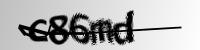

In [72]:
pred, orig_lbl, idx = pred_idx[0]
pth = path + orig_lbl + '.png'
print('Predicted:', pred)
print('True lbl:', orig_lbl)
Image.open(pth).convert('RGB')

Predicted: ddnyg
True lbl: ddmyg


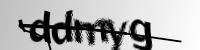

In [73]:
pred, orig_lbl, idx = pred_idx[1]
pth = path + orig_lbl + '.png'
print('Predicted:', pred)
print('True lbl:', orig_lbl)
Image.open(pth).convert('RGB')

Predicted: wgmwp
True lbl: wgnwp


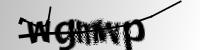

In [76]:
pred, orig_lbl, idx = pred_idx[2]
pth = path + orig_lbl + '.png'
print('Predicted:', pred)
print('True lbl:', orig_lbl)
Image.open(pth).convert('RGB')

### 3) Модель предсказывает последовательность короче 5 символов
Скорее всего данная ошибка означает то, что модель не уверена, символ ли перед ней или какой-то шум. Данную ошибку можно исправить путем выбора 2 наиболее вероятных символов, если видим, что модель не обладает достаточной уверенностью в текущем предсказании символа, а потом из 2 наиболее вероятных символов выбираем тот, что не blank, если увидим, что длина предсказанной на данный момент последовательности меньше 5.
В данных конкретных кейсах модель не может угадать символы, на которых много помех (перекрещивающиеся линии, шум)

In [77]:
short_errs = [(pred, orig) for (pred, orig) in errors if len(pred) < 5]
short_idx = []
for pred, lbl in short_errs:
    for idx, orig_lbl in enumerate(valid_labels):
        if lbl == orig_lbl:
            short_idx.append((pred, orig_lbl, idx))
print('Всего ошибок третьего типа встречается:', len(short_idx))
short_idx[:10]

Всего ошибок третьего типа встречается: 3


[('8ggg', '8eggg', 22), ('x3wg', 'cx3wg', 39), ('decc', 'ndecc', 199)]

Predicted: 8ggg
True lbl: 8eggg


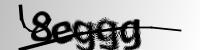

In [80]:
pred, orig_lbl, idx = short_idx[0]
pth = path + orig_lbl + '.png'
print('Predicted:', pred)
print('True lbl:', orig_lbl)
Image.open(pth).convert('RGB')

Predicted: x3wg
True lbl: cx3wg


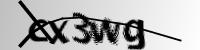

In [81]:
pred, orig_lbl, idx = short_idx[1]
pth = path + orig_lbl + '.png'
print('Predicted:', pred)
print('True lbl:', orig_lbl)
Image.open(pth).convert('RGB')

Predicted: decc
True lbl: ndecc


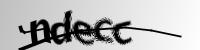

In [82]:
pred, orig_lbl, idx = short_idx[2]
pth = path + orig_lbl + '.png'
print('Predicted:', pred)
print('True lbl:', orig_lbl)
Image.open(pth).convert('RGB')

### Итог
Была обучена модель для распознавания картинок с символами капчи. В качестве датасета были взяты изображения из рекомендованных, однако выборка была сокращена до 1000 изображений из-за внутренних настроек платформы кэггл.

В качестве эксперимента во время поиска оптимальной модели рассматривалось использование дополнительных аугментаций (рандомный поворот изображения, добавление блюра), приведение изображения к одноканальному, использование трешхолдинга, dilation, opening на изображениях, изменение размера сверточных ядер в слоях модели (квадратные, прямоугольные (6,3), прямоугольные (3,6)), изменение размера батча (начиная от 3х картинок до 32 изображений в батче) для достижения оптимального качества модели. Большинсто из этих настроек не принесли особого увеличения качества модели, поэтому в итоговой версии кода от них не осталось следа. 
Наиболее оптимальным размером батча был размер 6-8. Ядро свертки (3, 6) способствовало наилучшему обучению модели, предположительно из-за того, что символы по горизонтали наиболее отличаются друг от друга. 

Обученная модель провалидирована на тестовой выборке, полученный результат:

- train_loss=0.0433
- valid_loss=0.0378
- cer=0.0060

В предсказаниях на валидационной выборке было выделено 3 вида наиболее часто встречающихся ошибок- одну из которых удалось исправить во время отладки кода декодера последовательности с помощью проверки на длину декодируемой последовательности (возможно, при более длительном обучении данные ошибки исчезли сами). 

Решение проблемы распознавания букв n, m, вероятно, можно решить несколькими путями:

1) Сбалансировать датасет, чтобы данные буквы встречались с примерно одинаковой частотой

2) Так как модель путалась в случае, когда на картинке с буквами n, m встречались шумы и помехи, можно применять дополнительные аугментации, чтобы повысить четкость расплывчатых букв. В найденных ошибочных кейсах буква m была сильно расплывчата, контуры данной буквы не всегда виднелись, либо она стояла очень близко к другой букве, что их контуры практически сливались, что могло повлиять на предсказание модели

Проблему недопредсказания последовательности можно решить путем устранения шума с картинок, так как в выявленных кейсах неразгаданная буква была всегда в окружении шума, причем шум мешал восприятию характерных элементов символа (например, палочка в букве е, либо же замыкание буквы n снизу делает ее не похожений ни на один лейбл), перекрещивание символа с крестом, также мешает идентификации символа.